In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
import re, datetime
from lifelines import KaplanMeierFitter
from datetime import date, timedelta

In [2]:
dict1={
    "4.2" : "27-6-2012 00:00:00" ,  
"4.3" : "26-6-2013 20:00:00" ,
"4.4" :  "25-6-2014 12:15:00" ,
"4.5" : "24-6-2015 20:00:00" ,
"4.6" :"22-6-2016 11:00:00",
"4.7" :  "28-6-2017 09:50:00",
"4.8" :  "27-6-2018 00:00:00"
}

In [3]:
dates=[
    "27-6-2012",
    "26-6-2013" ,
 "25-6-2014" ,
 "24-6-2015" ,
"22-6-2016",
  "28-6-2017",
  "27-6-2018",
 "27-6-2019"
]

In [4]:
def keepVal(activity):
    if activity=='NEW'or activity=='Assignee':
        return 1
    return 0

In [5]:
dX=pd.read_csv('db/ECF.csv')


In [6]:
#read the CSV file
df=pd.read_csv('db/ECF.csv')

df['creation_ts']=pd.to_datetime(df['creation_ts'])

In [7]:
allD=df
allD.head()

,When,Who,activity,bug_id,bug_severity,bug_status,creation_ts,resolution,version
0,2006-04-27 06:03:29,benno.baumgartner,NEW,138874,normal,NEW,2006-04-27 06:03:29,NaN,3.2
1,2005-07-19 10:40:40,emoffatt,NEW,104350,normal,NEW,2005-07-19 10:40:40,NaN,3.1
2,2019-01-03 13:11:25,joshgold,NEW,543156,enhancement,RESOLVED,2019-01-03 13:11:25,WONTFIX,4.8
3,2010-09-28 07:40:38,amj87.iitr,NEW,326401,normal,ASSIGNED,2010-09-28 07:40:38,NaN,3.7
4,2010-08-10 00:21:57,deepakazad,NEW,322196,normal,ASSIGNED,2010-08-10 00:21:57,NaN,3.7


In [8]:
df['keep']=df.apply(lambda x : keepVal(x['activity']), axis=1)
df = df[df['keep']==1]
df = df[['When', 'Who', 'activity', 'bug_id', 'bug_severity', 'bug_status',
       'creation_ts', 'resolution', 'version']]
df.head()

,When,Who,activity,bug_id,bug_severity,bug_status,creation_ts,resolution,version
0,2006-04-27 06:03:29,benno.baumgartner,NEW,138874,normal,NEW,2006-04-27 06:03:29,NaN,3.2
1,2005-07-19 10:40:40,emoffatt,NEW,104350,normal,NEW,2005-07-19 10:40:40,NaN,3.1
2,2019-01-03 13:11:25,joshgold,NEW,543156,enhancement,RESOLVED,2019-01-03 13:11:25,WONTFIX,4.8
3,2010-09-28 07:40:38,amj87.iitr,NEW,326401,normal,ASSIGNED,2010-09-28 07:40:38,NaN,3.7
4,2010-08-10 00:21:57,deepakazad,NEW,322196,normal,ASSIGNED,2010-08-10 00:21:57,NaN,3.7


In [9]:
df1=df
df2=df

In [10]:
df.sort_values(by='bug_id').head()

,When,Who,activity,bug_id,bug_severity,bug_status,creation_ts,resolution,version
102589,2001-10-10 21:34:46,andre_weinand,NEW,1,normal,CLOSED,2001-10-10 21:34:46,FIXED,2.0
105255,2001-10-10 21:34:47,andre_weinand,NEW,2,normal,RESOLVED,2001-10-10 21:34:47,FIXED,2.0
106812,2001-10-10 21:34:48,nick_edgar,NEW,3,normal,RESOLVED,2001-10-10 21:34:48,FIXED,2.0
164622,2001-10-26 12:02:22,valentam,Assignee,4,normal,RESOLVED,2001-10-10 21:34:49,FIXED,2.0
164621,2001-10-18 16:38:25,valentam,Assignee,4,normal,RESOLVED,2001-10-10 21:34:49,FIXED,2.0


In [11]:
df2=df2.groupby(by='bug_id', as_index=False).agg({'activity': pd.Series.nunique})
df2.head()

,bug_id,activity
0,1,1
1,2,1
2,3,1
3,4,2
4,6,2


In [12]:
df2.activity.unique()

array([1, 2], dtype=int64)

In [13]:
#remove the Assignee activity
df2 = df2[df2['activity']!=2]
df2.head()

,bug_id,activity
0,1,1
1,2,1
2,3,1
5,8,1
6,9,1


In [14]:
dfList = df2['bug_id'].tolist()

In [15]:
gap =allD[~allD.bug_id.isin(dfList)]
gap.sort_values(by=['bug_id','When'])

,When,Who,activity,bug_id,bug_severity,bug_status,creation_ts,resolution,version,keep
108198,2001-10-10 21:34:49,grant_gayed,NEW,4,normal,RESOLVED,2001-10-10 21:34:49,FIXED,2.0,1
164619,2001-10-12 11:30:02,jean-michel_lemieux,Assignee,4,normal,RESOLVED,2001-10-10 21:34:49,FIXED,2.0,1
164620,2001-10-12 11:30:02,jean-michel_lemieux,NEW,4,normal,RESOLVED,2001-10-10 21:34:49,FIXED,2.0,1
164621,2001-10-18 16:38:25,valentam,Assignee,4,normal,RESOLVED,2001-10-10 21:34:49,FIXED,2.0,1
164622,2001-10-26 12:02:22,valentam,Assignee,4,normal,RESOLVED,2001-10-10 21:34:49,FIXED,2.0,1
164623,2002-03-01 16:27:31,Kevin_McGuire,RESOLVED,4,normal,RESOLVED,2001-10-10 21:34:49,FIXED,2.0,0
164624,2002-03-01 16:27:31,Kevin_McGuire,FIXED,4,normal,RESOLVED,2001-10-10 21:34:49,FIXED,2.0,0
176125,2001-10-10 21:34:51,jeem,NEW,6,normal,RESOLVED,2001-10-10 21:34:51,INVALID,2.0,1
213842,2001-10-12 11:32:39,jean-michel_lemieux,Assignee,6,normal,RESOLVED,2001-10-10 21:34:51,INVALID,2.0,1
213843,2001-10-12 11:32:39,jean-michel_lemieux,NEW,6,normal,RESOLVED,2001-10-10 21:34:51,INVALID,2.0,1


In [16]:
df=gap
df.head()

,When,Who,activity,bug_id,bug_severity,bug_status,creation_ts,resolution,version,keep
0,2006-04-27 06:03:29,benno.baumgartner,NEW,138874,normal,NEW,2006-04-27 06:03:29,NaN,3.2,1
1,2005-07-19 10:40:40,emoffatt,NEW,104350,normal,NEW,2005-07-19 10:40:40,NaN,3.1,1
3,2010-09-28 07:40:38,amj87.iitr,NEW,326401,normal,ASSIGNED,2010-09-28 07:40:38,NaN,3.7,1
4,2010-08-10 00:21:57,deepakazad,NEW,322196,normal,ASSIGNED,2010-08-10 00:21:57,NaN,3.7,1
5,2011-01-19 06:58:53,ogierke,NEW,334770,enhancement,RESOLVED,2011-01-19 06:58:53,FIXED,3.6.2,1


In [17]:
df['When']=pd.to_datetime(df['When'])
df['creation_ts']=pd.to_datetime(df['creation_ts'])
df.head()

C:\Users\zeinab\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\zeinab\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,When,Who,activity,bug_id,bug_severity,bug_status,creation_ts,resolution,version,keep
0,2006-04-27 06:03:29,benno.baumgartner,NEW,138874,normal,NEW,2006-04-27 06:03:29,NaN,3.2,1
1,2005-07-19 10:40:40,emoffatt,NEW,104350,normal,NEW,2005-07-19 10:40:40,NaN,3.1,1
3,2010-09-28 07:40:38,amj87.iitr,NEW,326401,normal,ASSIGNED,2010-09-28 07:40:38,NaN,3.7,1
4,2010-08-10 00:21:57,deepakazad,NEW,322196,normal,ASSIGNED,2010-08-10 00:21:57,NaN,3.7,1
5,2011-01-19 06:58:53,ogierke,NEW,334770,enhancement,RESOLVED,2011-01-19 06:58:53,FIXED,3.6.2,1


In [18]:
#get the bugs reported at each month

xData=pd.DataFrame()
id_before_release=0
id_after_release=0
id_RBRB=0
id_RBFB=0
id_RBRA=0
id_RBFA=0
id_RARA=0
id_RAFA=0
c= -1
for x in dict1:
    data=pd.DataFrame()
    c=c+1
    for i in range(12):
        start_date = dict1[x]
        #print(start_date)
        date_time_obj = datetime.datetime.strptime(start_date, '%d-%m-%Y %H:%M:%S')
        #print('st',date_time_obj)
        k=date_time_obj + timedelta(30*i)
        l=date_time_obj + timedelta(30*(i+1))
        
        versionD= x
        version='^'+versionD

        mask= (df.version.str.contains(version, regex=True)) 

        maskp =(df.version.str.contains(version, regex=True))  & (df['creation_ts'] >= k)  & (df['creation_ts'] < l)


        dff = df.loc[mask]
        dffp = df.loc[maskp]
       # dffpp = df.loc[maskpp]

        id_RF=dffp.bug_id.unique()
       # id_RS=dffpp.bug_id.unique()

    
        TOTAL=len(id_RF)
        data=pd.DataFrame({"version": [versionD] , "total":[ TOTAL] , 'id_RF':[id_RF], "month":i+1 
  # , 'id_RS':[id_RS]
  
            
   })
    

        xData=xData.append(data)

In [19]:
#calculate the triaging time 
counter=0
total=pd.DataFrame()
data=pd.DataFrame()
#df3=pd.DataFrame()
total_all=pd.DataFrame()
for index, row in xData.iterrows():
    df3=df[df.bug_id.isin(row['id_RF'])]
    if df3.empty== False:
    
        version=row['version']
        month=row['month']
        #filter and keep only the new and assigne activity
        df3['keep']=(df3.apply(lambda x : keepVal(x['activity']), axis=1)).tolist()
        df3 = df3[df3['keep']==1]
        df3 = df3[['When', 'activity', 'bug_id']]

        df3['When']=pd.to_datetime(df3['When'])
    #get the first date of  new and assignee activity by getting minimum date value
        df3=df3.groupby(['bug_id','activity'])['When'].min().reset_index()
        #get the diffference between the date of new and date of assignee
        df3['diff'] = df3.groupby('bug_id')['When'].transform(lambda x: (x.max()-x.min()).days)
        df3=df3.groupby('bug_id').first().reset_index()
        df3= df3[['bug_id',
     'When',
     'diff']]
        df3['month'] = row['month']
        df3['version'] = row['version']
    counter=counter+1
    total=total.append(df3)
    total_all = total_all.append(df3)
    if counter==12 :
        total.to_csv('RQ3\\aEclipse-RF_'+str(version)+'.csv',index=False)
        counter=0
        total=pd.DataFrame()
    
#fg=tData[0]

C:\Users\zeinab\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\zeinab\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [20]:
total_all = total_all[['When', 'bug_id','diff', 'month', 'version']]

In [21]:
total_all.head()

,When,bug_id,diff,month,version
0,2012-06-27 03:06:47,383603,0.0,1.0,4.2
1,2012-06-27 11:19:40,383664,0.0,1.0,4.2
2,2012-06-27 15:21:02,383679,0.0,1.0,4.2
3,2012-08-21 11:32:37,383684,54.0,1.0,4.2
4,2012-06-28 07:46:07,383685,0.0,1.0,4.2


In [22]:
def shorten_date(date):
    st = str(date)
    return st[:st.find(' ')]

total_all['date_short'] = total_all.apply(lambda x : shorten_date(x['When']),axis=1)
total_all

,When,bug_id,diff,month,version,date_short
0,2012-06-27 03:06:47,383603,0.0,1.0,4.2,2012-06-27
1,2012-06-27 11:19:40,383664,0.0,1.0,4.2,2012-06-27
2,2012-06-27 15:21:02,383679,0.0,1.0,4.2,2012-06-27
3,2012-08-21 11:32:37,383684,54.0,1.0,4.2,2012-08-21
4,2012-06-28 07:46:07,383685,0.0,1.0,4.2,2012-06-28
5,2012-06-27 16:08:30,383686,0.0,1.0,4.2,2012-06-27
6,2012-06-28 13:40:53,383687,0.0,1.0,4.2,2012-06-28
7,2012-06-28 07:31:56,383703,0.0,1.0,4.2,2012-06-28
8,2012-07-26 01:00:34,383704,28.0,1.0,4.2,2012-07-26
9,2012-06-28 01:47:02,383715,0.0,1.0,4.2,2012-06-28


In [23]:
min_vals = total_all.set_index('When').groupby(pd.TimeGrouper(freq='M'))['diff'].median().reset_index().rename(index=str, columns={'diff':'value'})
min_vals['per_type'] = 50
seventyfive_vals = total_all.set_index('When').groupby(pd.TimeGrouper(freq='M'))['diff'].quantile(.75).reset_index().rename(index=str, columns={'diff':'value'})
seventyfive_vals['per_type'] = 75
one_hundred_vals = total_all.set_index('When').groupby(pd.TimeGrouper(freq='M'))['diff'].quantile(1).reset_index().rename(index=str, columns={'diff':'value'})
one_hundred_vals['per_type'] = 100

C:\Users\zeinab\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  """Entry point for launching an IPython kernel.
C:\Users\zeinab\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\zeinab\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  """


In [24]:
alldfs  = min_vals.append(seventyfive_vals)
alldfs = alldfs.append(one_hundred_vals)

In [25]:
alldfs = alldfs[alldfs['When']<'2018-12-25']

In [26]:
alldfs.head()

,When,value,per_type
0,2012-06-30,0.0,50
1,2012-07-31,0.0,50
2,2012-08-31,0.0,50
3,2012-09-30,0.0,50
4,2012-10-31,0.0,50


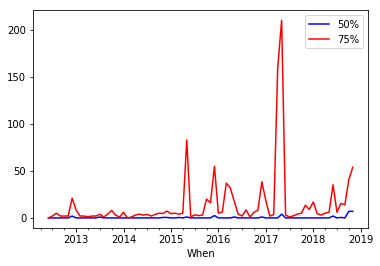

In [27]:
ax = plt.gca()
alldfs[alldfs['per_type']==50].plot(x='When',y='value',label='50%',color='blue',ax=ax)
alldfs[alldfs['per_type']==75].plot(x='When',y='value',label='75%',color='red',ax=ax)
#alldfs[alldfs['per_type']==100].plot(x='When',y='value',label='100%',color='green',ax=ax)

In [28]:
#####################################
########## UNTIL HERE ###############
#####################################

In [29]:
total_all.head()

,When,bug_id,diff,month,version,date_short
0,2012-06-27 03:06:47,383603,0.0,1.0,4.2,2012-06-27
1,2012-06-27 11:19:40,383664,0.0,1.0,4.2,2012-06-27
2,2012-06-27 15:21:02,383679,0.0,1.0,4.2,2012-06-27
3,2012-08-21 11:32:37,383684,54.0,1.0,4.2,2012-08-21
4,2012-06-28 07:46:07,383685,0.0,1.0,4.2,2012-06-28


In [30]:
#the month in total_all is since the release date, not since the creation date
total_all = total_all[['When','bug_id','diff','version']]
total_all['month']=-1
total_all

C:\Users\zeinab\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,When,bug_id,diff,version,month
0,2012-06-27 03:06:47,383603,0.0,4.2,-1
1,2012-06-27 11:19:40,383664,0.0,4.2,-1
2,2012-06-27 15:21:02,383679,0.0,4.2,-1
3,2012-08-21 11:32:37,383684,54.0,4.2,-1
4,2012-06-28 07:46:07,383685,0.0,4.2,-1
5,2012-06-27 16:08:30,383686,0.0,4.2,-1
6,2012-06-28 13:40:53,383687,0.0,4.2,-1
7,2012-06-28 07:31:56,383703,0.0,4.2,-1
8,2012-07-26 01:00:34,383704,28.0,4.2,-1
9,2012-06-28 01:47:02,383715,0.0,4.2,-1


In [31]:
total_all.version.unique()

array(['4.2', '4.3', '4.4', '4.5', '4.6', '4.7', '4.8'], dtype=object)

In [32]:
from dateutil import relativedelta

def get_month_diff(date1,version):
    version_date = pd.to_datetime(dict1[version])
    r = relativedelta.relativedelta(date1,version_date)
    ret = r.years * 12
    ret += r.months
    return ret

In [33]:
#I add +1 since if it is within the first month, the method returns zero
total_all['month'] = total_all.apply(lambda x: get_month_diff(x['When'],x['version'])+1,axis=1)


C:\Users\zeinab\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [34]:
total_all.sort_values(by='month',ascending=False)

,When,bug_id,diff,version,month
4,2018-12-28 05:42:51,390364,2284.0,4.2,79
239,2018-08-15 14:57:05,386054,2211.0,4.2,74
51,2018-08-14 16:41:52,386769,2198.0,4.2,74
32,2018-07-03 11:06:22,395296,2043.0,4.2,73
81,2018-06-06 08:44:32,394087,2032.0,4.2,72
62,2018-06-14 07:13:39,393834,2044.0,4.2,72
97,2018-03-13 18:15:17,401061,1849.0,4.2,69
41,2018-01-02 16:14:05,407251,1702.0,4.2,67
42,2018-01-02 16:28:09,407252,1702.0,4.2,67
19,2018-12-26 09:33:11,422949,1850.0,4.3,66


In [35]:
#just for testing
relativedelta.relativedelta(pd.to_datetime('2018-12-28'),pd.to_datetime('2012-06-27'))

relativedelta(years=+6, months=+6, days=+1)

In [36]:
#just for testing
relativedelta.relativedelta(pd.to_datetime('2012-06-28'),pd.to_datetime('2012-06-27'))

relativedelta(days=+1)

Rows with more than 12 months:77


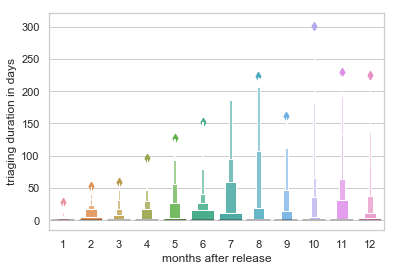

In [37]:
#release 4.2
release = '4.2'
print('Rows with more than 12 months:'+str(len(total_all[(total_all['version']==release) & (total_all['month']>12)])))
to_plot = total_all[(total_all['version']==release) & (total_all['month']<=12)]

import seaborn as sns
sns.set(style="whitegrid")

ax = sns.boxenplot(x=to_plot['month'], y=to_plot['diff'])
ax.set_xlabel("months after release")
ax.set_ylabel("triaging duration in days")
plt.savefig('rq3t4-2.pdf')
#plt.yticks(np.arange(4920, 5000, 10))

Rows with more than 12 months:45


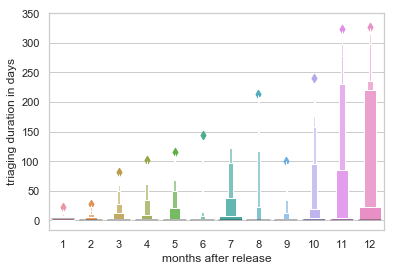

In [38]:
#release 4.3
release = '4.3'
print('Rows with more than 12 months:'+str(len(total_all[(total_all['version']==release) & (total_all['month']>12)])))
to_plot = total_all[(total_all['version']==release) & (total_all['month']<=12)]
 
import seaborn as sns
sns.set(style="whitegrid")

ax = sns.boxenplot(x=to_plot['month'], y=to_plot['diff'])
ax.set_xlabel("months after release")
ax.set_ylabel("triaging duration in days")
plt.savefig('rq3t4-3.pdf')
#plt.yticks(np.arange(4920, 5000, 10))

Rows with more than 12 months:33


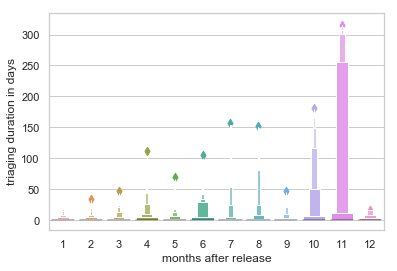

In [39]:
#release 4.4
release = '4.4'
print('Rows with more than 12 months:'+str(len(total_all[(total_all['version']==release) & (total_all['month']>12)])))
to_plot = total_all[(total_all['version']==release) & (total_all['month']<=12)]
 
import seaborn as sns
sns.set(style="whitegrid")

ax = sns.boxenplot(x=to_plot['month'], y=to_plot['diff'])
#plt.yticks(np.arange(4920, 5000, 10))
ax.set_xlabel("months after release")
ax.set_ylabel("triaging duration in days")
plt.savefig('rq3t4-4.pdf')

Rows with more than 12 months:80


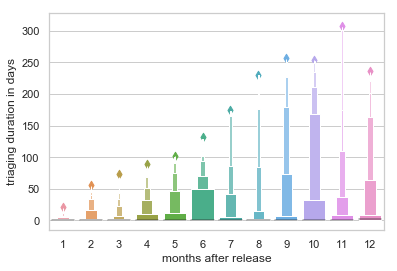

In [40]:
#release 4.5
release = '4.5'
print('Rows with more than 12 months:'+str(len(total_all[(total_all['version']==release) & (total_all['month']>12)])))
to_plot = total_all[(total_all['version']==release) & (total_all['month']<=12)]
 
import seaborn as sns
sns.set(style="whitegrid")

ax = sns.boxenplot(x=to_plot['month'], y=to_plot['diff'])
#plt.yticks(np.arange(4920, 5000, 10))

ax.set_xlabel("months after release")
ax.set_ylabel("triaging duration in days")
plt.savefig('rq3t4-5.pdf')
#4.5

Rows with more than 12 months:33


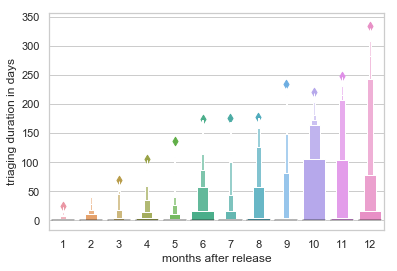

In [41]:
#release 4.6
release = '4.6'
print('Rows with more than 12 months:'+str(len(total_all[(total_all['version']==release) & (total_all['month']>12)])))
to_plot = total_all[(total_all['version']==release) & (total_all['month']<=12)]
 
import seaborn as sns
sns.set(style="whitegrid")

ax = sns.boxenplot(x=to_plot['month'], y=to_plot['diff'])
ax.set_xlabel("months after release")
ax.set_ylabel("triaging duration in days")
plt.savefig('rq3t4-6.pdf')
#plt.yticks(np.arange(4920, 5000, 10))

Rows with more than 12 months:28


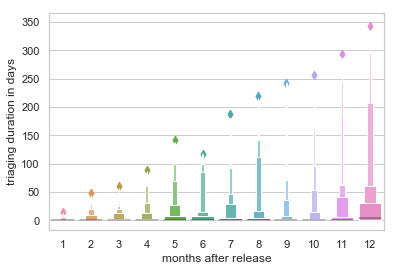

In [42]:
#release 4.7
release = '4.7'
print('Rows with more than 12 months:'+str(len(total_all[(total_all['version']==release) & (total_all['month']>12)])))
to_plot = total_all[(total_all['version']==release) & (total_all['month']<=12)]
 
import seaborn as sns
sns.set(style="whitegrid")

ax = sns.boxenplot(x=to_plot['month'], y=to_plot['diff'])
ax.set_xlabel("months after release")
ax.set_ylabel("triaging duration in days")
plt.savefig('rq3t4-7.pdf')
#plt.yticks(np.arange(4920, 5000, 10))

Rows with more than 12 months:0


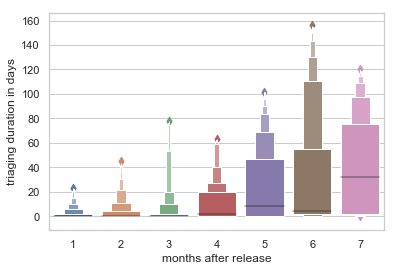

In [43]:
#release 4.8
release = '4.8'
print('Rows with more than 12 months:'+str(len(total_all[(total_all['version']==release) & (total_all['month']>12)])))
to_plot = total_all[(total_all['version']==release) & (total_all['month']<=12)]
 
import seaborn as sns
sns.set(style="whitegrid")

ax = sns.boxenplot(x=to_plot['month'], y=to_plot['diff'])
ax.set_xlabel("months after release")
ax.set_ylabel("triaging duration in days")
plt.savefig('rq3t4-8.pdf')
#plt.yticks(np.arange(4920, 5000, 10))

In [44]:
total_all.version.unique()

array(['4.2', '4.3', '4.4', '4.5', '4.6', '4.7', '4.8'], dtype=object)